In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer, MultiLabelBinarizer

import tensorflow as tf
# from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
# from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session

import keras
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam

### model py files
import CNN_BatchN as batchN

In [2]:
### Choose which GPU to use - HEX SERVER ONLY. Go to https://hex.cs.bath.ac.uk/usage for current usage
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

### Prevent GPU memory overflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### E. CNN_Baseline + Haze Removal + Data Augmentation + Batch Normalization + Drop out + Early Stopping

In [3]:
# Import dataset
DATASET_PATH = 'dataset/'
TRAIN_PATH = DATASET_PATH + 'train_file'
TEST_PATH = DATASET_PATH + 'test_file'

TRAIN_CSV_PATH = DATASET_PATH + 'train_label.csv'
TEST_CSV_PATH = DATASET_PATH + 'test_label.csv'

df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

df_train['tags'] = df_train['tags'].apply(lambda x: x.split(' '))
df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

X_train_files_o = np.array(df_train['image_name'].tolist()) # filenames
X_train_files_o.reshape((X_train_files_o.shape[0], 1))
y_train_o = np.array(df_train['tags'].tolist(), dtype=object) # train image tags (ground truth)
y_test_o = np.array(df_test['tags'].tolist(), dtype=object) # test image tags (ground truth)

tags = df_train['tags'].values
flat_list = [item for sublist in tags for item in sublist]
tags_unique, tags_count = np.unique(flat_list, return_counts=True)
labels = list(tags_unique)

In [4]:
# Define learning curve and evaluation metric (f-2 Beta score):

def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# F-Beta Score
def fbeta_score_K(y_true, y_pred):
    beta = 2
    beta_squared = beta ** 2
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

from sklearn.metrics import fbeta_score


def calc_acc(y_test, y_pred, labels=labels, threshold=0.2):
    
    array_labels = np.array(labels)
    test = y_test
    pred = y_pred
    
    # Binarize pred to 0 and 1...
    binarizer = Binarizer(threshold=threshold)
    pred = binarizer.fit_transform(pred)
    # 0 and 1 to False and True for boolean indexing...
    pred = pred > 0
    
    preds = []
    for row in pred:
        preds.append(array_labels[row])
    
    mlb = MultiLabelBinarizer(classes=array_labels)
    
    test = mlb.fit_transform(test)
    preds = mlb.transform(preds)
    score = fbeta_score(test, preds, beta=2, average='weighted')
    
    return score


def plot(result, csv_filename):
    train_history = pd.DataFrame(result)

    train_history.to_csv(csv_filename, sep=',')
    plt.plot(train_history['fbeta_score_K'])
    plt.plot(train_history['val_fbeta_score_K'])
    plt.title('model accuracy')
    plt.ylabel('fbeta_score_K')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(train_history['loss'])
    plt.plot(train_history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [5]:
# data_generator for keras CNN
def data_generator(X_train_files_o, y_train_o, base_flg, batch_size):
    
    X_train_files, X_val_files, y_train, y_val = train_test_split(X_train_files_o, y_train_o, test_size=0.2, random_state=0)

    train_df = pd.DataFrame(list(zip(X_train_files, y_train)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files, y_val)), columns = ['image_name', 'tags'])

    train_df['tags'] = train_df['tags']
    val_df['tags'] = val_df['tags']
    
    if base_flg:
        train_datagen = ImageDataGenerator(
            rescale=1./255
            )
    else:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
            )
        
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        )

    val_datagen = ImageDataGenerator(
        rescale=1./255
        )

    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        )

    test_datagen = ImageDataGenerator(
        rescale=1./255
        )

    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        shuffle=False,
        )
    
    return train_generator,val_generator,test_generator

In [6]:
# Parameters
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
EPOCHS = 100
REG_STRENGTH = 0.01 # Regularization Strength
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.
BATCH_SIZE = 128
LR = 0.0001 # Learning Rate

### Hyperparameter grid
DROPOUT_RATE = [0.1, 0.25, 0.5]
PATIENCE = [5, 10, 20]


In [7]:
### Import model
results = []

def run(BATCH_SIZE, DROPOUT_RATE, PATIENCE, LR):
    

    for dropout_rate in DROPOUT_RATE:
        print('\tdropout_rate =', dropout_rate)
        for patience in PATIENCE:
            print('\t\tpatience =', patience)
            
            train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o, \
                                                                            False, BATCH_SIZE)
            model_path = 'CNN_last_weights' + '.h5'
            adam = Adam(learning_rate=LR)
            cnn_batch_model = batchN.create_model(dropout_rate)
            clear_session() # tf backend
            cnn_batch_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

            callbacks = [
                ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
                ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
                EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience),
            ]

            history = cnn_batch_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, \
                                          callbacks=callbacks, workers=WORKERS, use_multiprocessing=False, \
                                          max_queue_size=MAXQ)



            cnn_batch_model.load_weights(model_path)

            y_pred = cnn_batch_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, \
                                             max_queue_size=MAXQ)
            
            test_score = calc_acc(y_test_o, y_pred)
            
            results.append({'dropout_rate':dropout_rate, 'patience':patience, 'history':history.history, \
                            'test_f2_score':test_score})

In [8]:
run(BATCH_SIZE, DROPOUT_RATE, PATIENCE, LR)

	dropout_rate = 0.1
		patience = 5
Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/100
203/203 [==============================] - 57s 248ms/step - loss: 0.2584 - fbeta_score_K: 0.6031 - val_loss: 0.2798 - val_fbeta_score_K: 0.5289
Epoch 2/100
203/203 [==============================] - 50s 244ms/step - loss: 0.1846 - fbeta_score_K: 0.6830 - val_loss: 0.2660 - val_fbeta_score_K: 0.5926
Epoch 3/100
203/203 [==============================] - 51s 248ms/step - loss: 0.1707 - fbeta_score_K: 0.7100 - val_loss: 0.1989 - val_fbeta_score_K: 0.6470
Epoch 4/100
203/203 [==============================] - 50s 244ms/step - loss: 0.1606 - fbeta_score_K: 0.7258 - val_loss: 0.2026 - val_fbeta_score_K: 0.6788
Epoch 5/100
203/203 [==============================] - 51s 249ms/step - loss: 0.1521 - fbeta_score_K: 0.7431 - val_loss: 0.1571 - val_fbeta_score_K: 0.741

203/203 [==============================] - 56s 272ms/step - loss: 0.1295 - fbeta_score_K: 0.7808 - val_loss: 0.1264 - val_fbeta_score_K: 0.7861
Epoch 12/100
203/203 [==============================] - 53s 260ms/step - loss: 0.1277 - fbeta_score_K: 0.7843 - val_loss: 0.1417 - val_fbeta_score_K: 0.7639
Epoch 13/100
203/203 [==============================] - 53s 257ms/step - loss: 0.1271 - fbeta_score_K: 0.7850 - val_loss: 0.1300 - val_fbeta_score_K: 0.7906
Epoch 14/100
203/203 [==============================] - 54s 263ms/step - loss: 0.1241 - fbeta_score_K: 0.7901 - val_loss: 0.1214 - val_fbeta_score_K: 0.7970
Epoch 15/100
203/203 [==============================] - 55s 269ms/step - loss: 0.1240 - fbeta_score_K: 0.7905 - val_loss: 0.1411 - val_fbeta_score_K: 0.7671
Epoch 16/100
203/203 [==============================] - 55s 269ms/step - loss: 0.1231 - fbeta_score_K: 0.7922 - val_loss: 0.1218 - val_fbeta_score_K: 0.7939
Epoch 17/100
203/203 [==============================] - 55s 266ms/step 

Epoch 22/100
203/203 [==============================] - 67s 327ms/step - loss: 0.1169 - fbeta_score_K: 0.8025 - val_loss: 0.1197 - val_fbeta_score_K: 0.8028
Epoch 23/100
203/203 [==============================] - 68s 331ms/step - loss: 0.1159 - fbeta_score_K: 0.8043 - val_loss: 0.1170 - val_fbeta_score_K: 0.8128
Epoch 24/100
203/203 [==============================] - 67s 327ms/step - loss: 0.1156 - fbeta_score_K: 0.8052 - val_loss: 0.1206 - val_fbeta_score_K: 0.8038
Epoch 25/100
203/203 [==============================] - 66s 319ms/step - loss: 0.1133 - fbeta_score_K: 0.8089 - val_loss: 0.1159 - val_fbeta_score_K: 0.8138
Epoch 26/100
203/203 [==============================] - 65s 317ms/step - loss: 0.1156 - fbeta_score_K: 0.8062 - val_loss: 0.1370 - val_fbeta_score_K: 0.7855
Epoch 27/100
203/203 [==============================] - 66s 320ms/step - loss: 0.1114 - fbeta_score_K: 0.8119 - val_loss: 0.1266 - val_fbeta_score_K: 0.7980
Epoch 28/100
203/203 [==============================] - 65

Epoch 74/100
203/203 [==============================] - 62s 299ms/step - loss: 0.0943 - fbeta_score_K: 0.8413 - val_loss: 0.1151 - val_fbeta_score_K: 0.8323
Epoch 75/100
203/203 [==============================] - 58s 283ms/step - loss: 0.0954 - fbeta_score_K: 0.8388 - val_loss: 0.1015 - val_fbeta_score_K: 0.8441
Epoch 76/100
203/203 [==============================] - 60s 293ms/step - loss: 0.0935 - fbeta_score_K: 0.8420 - val_loss: 0.1060 - val_fbeta_score_K: 0.8375
Epoch 77/100
203/203 [==============================] - 59s 286ms/step - loss: 0.0939 - fbeta_score_K: 0.8406 - val_loss: 0.1103 - val_fbeta_score_K: 0.8438
Epoch 78/100
203/203 [==============================] - 60s 290ms/step - loss: 0.0926 - fbeta_score_K: 0.8446 - val_loss: 0.1019 - val_fbeta_score_K: 0.8410
Epoch 79/100
203/203 [==============================] - 61s 296ms/step - loss: 0.0930 - fbeta_score_K: 0.8424 - val_loss: 0.1029 - val_fbeta_score_K: 0.8463
Epoch 80/100
203/203 [==============================] - 62

Epoch 25/100
203/203 [==============================] - 59s 286ms/step - loss: 0.1187 - fbeta_score_K: 0.7997 - val_loss: 0.1504 - val_fbeta_score_K: 0.7703
Epoch 26/100
203/203 [==============================] - 61s 296ms/step - loss: 0.1208 - fbeta_score_K: 0.7951 - val_loss: 0.1258 - val_fbeta_score_K: 0.8006
Epoch 27/100
203/203 [==============================] - 61s 295ms/step - loss: 0.1194 - fbeta_score_K: 0.7988 - val_loss: 0.1202 - val_fbeta_score_K: 0.8047
Epoch 28/100
203/203 [==============================] - 59s 287ms/step - loss: 0.1175 - fbeta_score_K: 0.8012 - val_loss: 0.1321 - val_fbeta_score_K: 0.7802
Epoch 29/100
203/203 [==============================] - 60s 291ms/step - loss: 0.1170 - fbeta_score_K: 0.8030 - val_loss: 0.1575 - val_fbeta_score_K: 0.7749
Epoch 30/100
203/203 [==============================] - 59s 285ms/step - loss: 0.1163 - fbeta_score_K: 0.8034 - val_loss: 0.1272 - val_fbeta_score_K: 0.7892
Epoch 31/100
203/203 [==============================] - 59

Epoch 44/100
203/203 [==============================] - 46s 221ms/step - loss: 0.1085 - fbeta_score_K: 0.8174 - val_loss: 0.1280 - val_fbeta_score_K: 0.8152
Epoch 45/100
203/203 [==============================] - 48s 231ms/step - loss: 0.1097 - fbeta_score_K: 0.8146 - val_loss: 0.1132 - val_fbeta_score_K: 0.8169
Epoch 00045: early stopping
		patience = 20
Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/100
203/203 [==============================] - 50s 237ms/step - loss: 0.2747 - fbeta_score_K: 0.5899 - val_loss: 0.2904 - val_fbeta_score_K: 0.5916
Epoch 2/100
203/203 [==============================] - 48s 237ms/step - loss: 0.2027 - fbeta_score_K: 0.6527 - val_loss: 0.3509 - val_fbeta_score_K: 0.5975
Epoch 3/100
203/203 [==============================] - 48s 232ms/step - loss: 0.1851 - fbeta_score_K: 0.6850 - val_loss: 0.2771 - val_fbeta_sco

Epoch 50/100
203/203 [==============================] - 47s 227ms/step - loss: 0.1083 - fbeta_score_K: 0.8189 - val_loss: 0.1111 - val_fbeta_score_K: 0.8329
Epoch 51/100
203/203 [==============================] - 46s 225ms/step - loss: 0.1079 - fbeta_score_K: 0.8198 - val_loss: 0.1094 - val_fbeta_score_K: 0.8248
Epoch 52/100
203/203 [==============================] - 47s 230ms/step - loss: 0.1069 - fbeta_score_K: 0.8204 - val_loss: 0.1126 - val_fbeta_score_K: 0.8292
Epoch 53/100
203/203 [==============================] - 47s 230ms/step - loss: 0.1070 - fbeta_score_K: 0.8193 - val_loss: 0.1179 - val_fbeta_score_K: 0.8063
Epoch 54/100
203/203 [==============================] - 48s 232ms/step - loss: 0.1062 - fbeta_score_K: 0.8214 - val_loss: 0.1165 - val_fbeta_score_K: 0.8233
Epoch 55/100
203/203 [==============================] - 48s 232ms/step - loss: 0.1055 - fbeta_score_K: 0.8215 - val_loss: 0.1122 - val_fbeta_score_K: 0.8356
Epoch 56/100
203/203 [==============================] - 47

203/203 [==============================] - 48s 235ms/step - loss: 0.1523 - fbeta_score_K: 0.7423 - val_loss: 0.1990 - val_fbeta_score_K: 0.7052
Epoch 12/100
203/203 [==============================] - 47s 227ms/step - loss: 0.1498 - fbeta_score_K: 0.7450 - val_loss: 0.2302 - val_fbeta_score_K: 0.6891
Epoch 13/100
203/203 [==============================] - 45s 220ms/step - loss: 0.1486 - fbeta_score_K: 0.7476 - val_loss: 0.1635 - val_fbeta_score_K: 0.7235
Epoch 14/100
203/203 [==============================] - 47s 228ms/step - loss: 0.1462 - fbeta_score_K: 0.7524 - val_loss: 0.1964 - val_fbeta_score_K: 0.7105
Epoch 15/100
203/203 [==============================] - 48s 233ms/step - loss: 0.1429 - fbeta_score_K: 0.7580 - val_loss: 0.1720 - val_fbeta_score_K: 0.7260
Epoch 16/100
203/203 [==============================] - 48s 232ms/step - loss: 0.1418 - fbeta_score_K: 0.7578 - val_loss: 0.1939 - val_fbeta_score_K: 0.7141
Epoch 17/100
203/203 [==============================] - 47s 230ms/step 

Epoch 44/100
203/203 [==============================] - 46s 225ms/step - loss: 0.1157 - fbeta_score_K: 0.8039 - val_loss: 0.1966 - val_fbeta_score_K: 0.6618
Epoch 45/100
203/203 [==============================] - 47s 226ms/step - loss: 0.1182 - fbeta_score_K: 0.7994 - val_loss: 0.1316 - val_fbeta_score_K: 0.7798
Epoch 46/100
203/203 [==============================] - 46s 222ms/step - loss: 0.1179 - fbeta_score_K: 0.8012 - val_loss: 0.1452 - val_fbeta_score_K: 0.7730
Epoch 47/100
203/203 [==============================] - 47s 227ms/step - loss: 0.1157 - fbeta_score_K: 0.8038 - val_loss: 0.1561 - val_fbeta_score_K: 0.7554
Epoch 48/100
203/203 [==============================] - 46s 225ms/step - loss: 0.1170 - fbeta_score_K: 0.8026 - val_loss: 0.1441 - val_fbeta_score_K: 0.7745
Epoch 49/100
203/203 [==============================] - 46s 224ms/step - loss: 0.1163 - fbeta_score_K: 0.8039 - val_loss: 0.1516 - val_fbeta_score_K: 0.7701
Epoch 50/100
203/203 [==============================] - 46

Epoch 28/100
203/203 [==============================] - 46s 224ms/step - loss: 0.1258 - fbeta_score_K: 0.7863 - val_loss: 0.1722 - val_fbeta_score_K: 0.7322
Epoch 29/100
203/203 [==============================] - 47s 226ms/step - loss: 0.1260 - fbeta_score_K: 0.7877 - val_loss: 0.1437 - val_fbeta_score_K: 0.7698
Epoch 30/100
203/203 [==============================] - 46s 224ms/step - loss: 0.1273 - fbeta_score_K: 0.7866 - val_loss: 0.1532 - val_fbeta_score_K: 0.7454
Epoch 31/100
203/203 [==============================] - 47s 227ms/step - loss: 0.1242 - fbeta_score_K: 0.7892 - val_loss: 0.1491 - val_fbeta_score_K: 0.7491
Epoch 32/100
203/203 [==============================] - 46s 222ms/step - loss: 0.1231 - fbeta_score_K: 0.7926 - val_loss: 0.1499 - val_fbeta_score_K: 0.7532
Epoch 33/100
203/203 [==============================] - 46s 222ms/step - loss: 0.1229 - fbeta_score_K: 0.7918 - val_loss: 0.1553 - val_fbeta_score_K: 0.7479
Epoch 34/100
203/203 [==============================] - 46

203/203 [==============================] - 49s 238ms/step - loss: 0.1068 - fbeta_score_K: 0.8183 - val_loss: 0.1303 - val_fbeta_score_K: 0.7936
Epoch 81/100
203/203 [==============================] - 47s 231ms/step - loss: 0.1076 - fbeta_score_K: 0.8173 - val_loss: 0.1302 - val_fbeta_score_K: 0.7934
Epoch 82/100
203/203 [==============================] - 47s 229ms/step - loss: 0.1061 - fbeta_score_K: 0.8198 - val_loss: 0.1303 - val_fbeta_score_K: 0.7926
Epoch 83/100
203/203 [==============================] - 49s 236ms/step - loss: 0.1063 - fbeta_score_K: 0.8193 - val_loss: 0.1300 - val_fbeta_score_K: 0.7931
Epoch 84/100
203/203 [==============================] - 47s 230ms/step - loss: 0.1063 - fbeta_score_K: 0.8189 - val_loss: 0.1303 - val_fbeta_score_K: 0.7928
Epoch 85/100
203/203 [==============================] - 48s 234ms/step - loss: 0.1056 - fbeta_score_K: 0.8194 - val_loss: 0.1302 - val_fbeta_score_K: 0.7931
Epoch 86/100
203/203 [==============================] - 47s 230ms/step 

[{'dropout_rate': 0.1,
  'patience': 5,
  'history:': {'loss': [0.2155618518590927,
    0.18069636821746826,
    0.1678265631198883,
    0.15791217982769012,
    0.15160508453845978,
    0.14844833314418793,
    0.14344537258148193,
    0.1406351923942566,
    0.13768446445465088,
    0.13470768928527832,
    0.1330738365650177,
    0.13011434674263,
    0.12905560433864594,
    0.12686719000339508,
    0.12573525309562683,
    0.12457149475812912,
    0.12315353751182556,
    0.12099992483854294,
    0.12101463228464127,
    0.1190231665968895,
    0.11758662760257721,
    0.11740610748529434,
    0.11652585119009018,
    0.11626031994819641,
    0.11461982131004333,
    0.11409489065408707,
    0.11345000565052032,
    0.11272605508565903,
    0.112360879778862,
    0.11109528690576553,
    0.11158417910337448,
    0.10998046398162842,
    0.10899940878152847,
    0.1085360124707222,
    0.10750873386859894,
    0.10794727504253387,
    0.10700159519910812,
    0.10666679590940475,
 

In [17]:
df_results = pd.DataFrame(results)

In [32]:
df_results.sort_values('test_f2_score', ascending=False)

,dropout_rate,patience,history:,test_f2_score
2,0.10,20,"{'loss': [0.21369341015815735, 0.1795995533466...",0.902200
5,0.25,20,"{'loss': [0.23109519481658936, 0.1975099742412...",0.894058
0,0.10,5,"{'loss': [0.2155618518590927, 0.18069636821746...",0.892885
1,0.10,10,"{'loss': [0.2198447436094284, 0.18271651864051...",0.892237
4,0.25,10,"{'loss': [0.22822752594947815, 0.1963591426610...",0.878748
3,0.25,5,"{'loss': [0.2322988659143448, 0.19618546962738...",0.876998
8,0.50,20,"{'loss': [0.2617758512496948, 0.21884529292583...",0.861447
7,0.50,10,"{'loss': [0.2645259201526642, 0.21780353784561...",0.847950
6,0.50,5,"{'loss': [0.25560057163238525, 0.2172423899173...",0.818046


In [33]:
df_results.to_csv('hyperparameter_search_CNN_BatchN_results.csv', index=False)

In [18]:
train_history = df_results['history:']

In [20]:
train_history[0]

{'loss': [0.2155618518590927,
  0.18069636821746826,
  0.1678265631198883,
  0.15791217982769012,
  0.15160508453845978,
  0.14844833314418793,
  0.14344537258148193,
  0.1406351923942566,
  0.13768446445465088,
  0.13470768928527832,
  0.1330738365650177,
  0.13011434674263,
  0.12905560433864594,
  0.12686719000339508,
  0.12573525309562683,
  0.12457149475812912,
  0.12315353751182556,
  0.12099992483854294,
  0.12101463228464127,
  0.1190231665968895,
  0.11758662760257721,
  0.11740610748529434,
  0.11652585119009018,
  0.11626031994819641,
  0.11461982131004333,
  0.11409489065408707,
  0.11345000565052032,
  0.11272605508565903,
  0.112360879778862,
  0.11109528690576553,
  0.11158417910337448,
  0.10998046398162842,
  0.10899940878152847,
  0.1085360124707222,
  0.10750873386859894,
  0.10794727504253387,
  0.10700159519910812,
  0.10666679590940475,
  0.10690733790397644],
 'fbeta_score_K': [0.6389853358268738,
  0.6909007430076599,
  0.7148135900497437,
  0.7319627404212952,


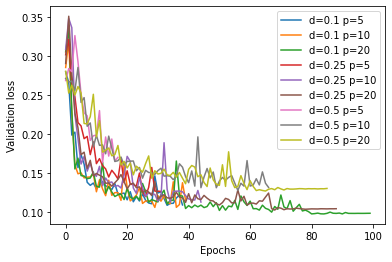

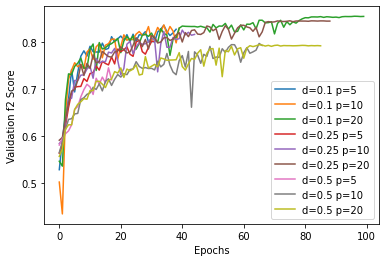

d stands for dropout rate and p for early stopping patience.


In [28]:
for i in range(df_results.shape[0]):
    row = df_results.iloc[i,:]
    plt.plot(row['history:']['val_loss'], label='d={} p={}'.format(row['dropout_rate'], row['patience']))
    plt.xlabel('Epochs')
    plt.ylabel('Validation loss')
plt.legend()
plt.show()

for i in range(df_results.shape[0]):
    row = df_results.iloc[i,:]
    plt.plot(row['history:']['val_fbeta_score_K'], label='d={} p={}'.format(row['dropout_rate'], row['patience']))
    plt.xlabel('Epochs')
    plt.ylabel('Validation f2 Score')    
plt.legend()
plt.show()

print('d stands for dropout rate and p for early stopping patience.')

In [31]:
for i in range(df_results.shape[0]):
    row = df_results.iloc[i,:]
    print('d={} p={} test_f2_score={}'.format(row['dropout_rate'], row['patience'], round(row['test_f2_score'], 3)))

d=0.1 p=5 test_f2_score=0.893
d=0.1 p=10 test_f2_score=0.892
d=0.1 p=20 test_f2_score=0.902
d=0.25 p=5 test_f2_score=0.877
d=0.25 p=10 test_f2_score=0.879
d=0.25 p=20 test_f2_score=0.894
d=0.5 p=5 test_f2_score=0.818
d=0.5 p=10 test_f2_score=0.848
d=0.5 p=20 test_f2_score=0.861
